# Analyse Rating

Fragen:

- Hat die Transaktionsbewertung Einfluss auf die wirtschaftliche Leistung?

Zusammenfassung Erkenntnisse:
- Die Ratings schwanken über die Zeit, sind in der Mitte der Zeitspanne ganz unten
- Online hat die schlechtesten Ratings -> Ausfälle für verantwortlich? ist in Monat 5 ganz unten
- Tablet Basic hat die schlechtesten Ratings -> geht über die Monate kontinurlich nach unten, hat dann aber einen rasanten Ansteig


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Datenaufbereitung


In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

Wie verhält sich das Rating bei den unterschiedlichen Modellen? -> Tablet Basic ist wohl deutlich unbeliebter

Erklärung Catplot (Boxplot):

- Die zentrale Linie in jeder Box zeigt den Median der Bewertungen an.
- Die Kanten der Box zeigen das untere (25. Perzentil) und obere (75. Perzentil) Quartil der Daten.
- Die "Whisker" (vertikalen Linien, die aus der Box herausragen) erstrecken sich bis zu den am weitesten entfernten Punkten, die keine Ausreißer sind.
- Punkte, die als Ausreißer gelten (weit entfernt von den Quartilen), werden als individuelle Punkte dargestellt.

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


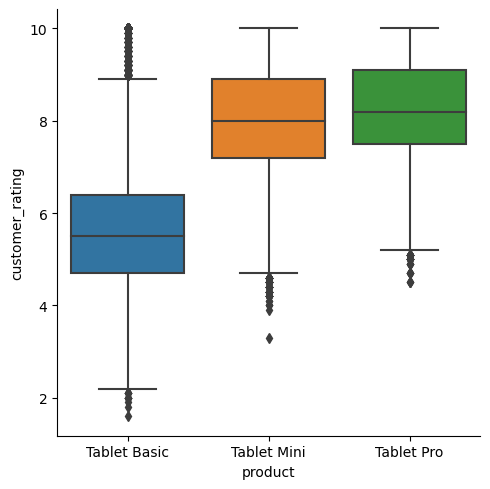

In [4]:
sns.catplot(data=df_reg_main, x="product", y="customer_rating", 
kind="box")


Wie verhält sich das Rating bezogen auf die Regionen und den Marktplatz?

- Die Ratings für Phone und Store sind generell höher, haben aber einige Ausreißer nach unten.
- Dadurch, dass die Online-Ratings im Schnitt generell niedriger sind, gibt es bei Online keine Ausreißer.

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


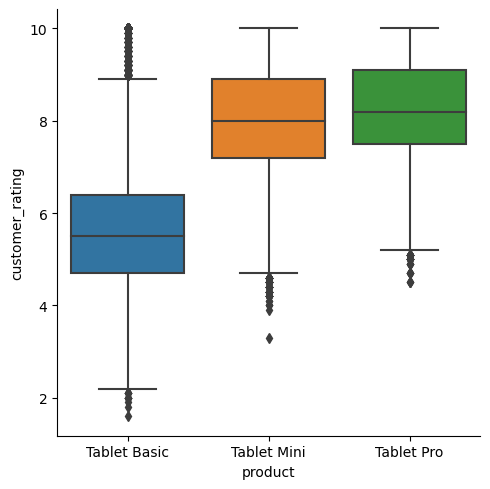

In [5]:

sns.catplot(data=df_reg_main, x="product", y="customer_rating", 
kind="box")

Verändert sich das Rating über die Zeit? -> Rating geht in der Mitte der Zeitspanne deutlich nach unten


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


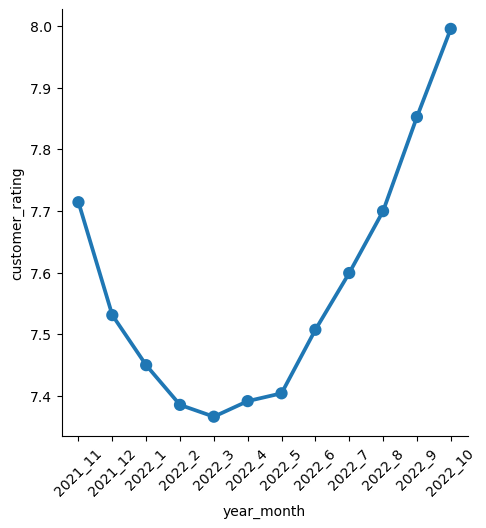

In [6]:
#sns.lineplot(x='date', y='customer_rating', data=df_reg_main)
cat = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", errorbar=None);
cat.set_xticklabels(rotation=45)
plt.show()


Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Region? -> Drop in der Mitte, C am schlechtsten


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


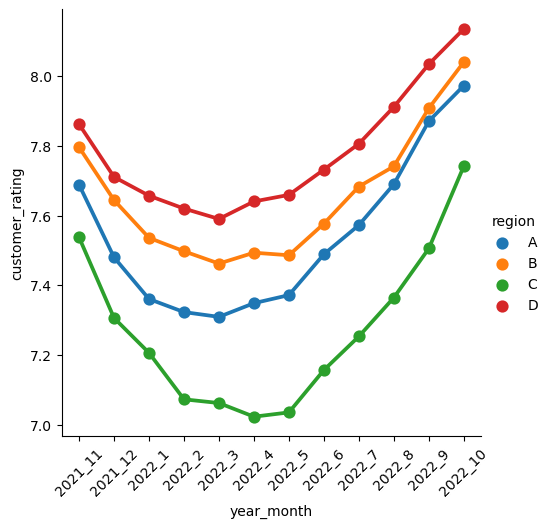

In [7]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="region", errorbar=None);
plot.set_xticklabels(rotation=45)
plt.show()

Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Marktplatz? Online droppt in der Mitte und ist tendenziell am schlechtesten

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


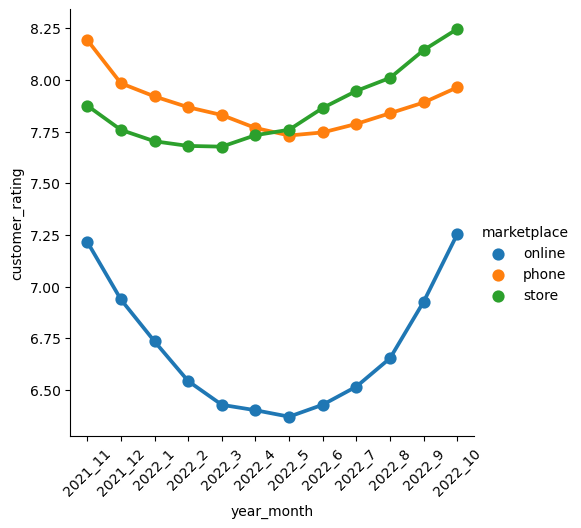

In [8]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="marketplace", errorbar=None);
plot.set_xticklabels(rotation=45)
plt.show()

Wie verhält sich das durchschnittliche Rating über die Zeit, gruppiert nach Produkt? Mini Und Basic sinken

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


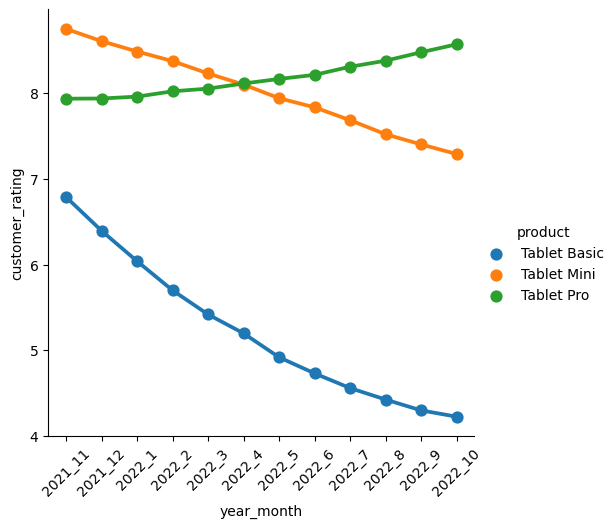

In [9]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="product", errorbar=None)
plot.set_xticklabels(rotation=45)
plt.show()
